In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.stats import wilcoxon

In [2]:
os.getcwd()

'/home/sam/tbi_ct_lesion_segmentation/stats'

In [3]:
results_dir = "results"
#results_dir = os.path.join("..", "results")

In [4]:
os.listdir(results_dir)

['umd_test', 'vcu_test', 'nih_test', 'vu_test']

In [5]:
training_patterns = [os.path.join(results_dir, x) for x in os.listdir(results_dir)
                    if not os.path.isdir(x)]

In [6]:
training_patterns

['results/umd_test', 'results/vcu_test', 'results/nih_test', 'results/vu_test']

In [7]:
result_files = [[os.path.join(training_pattern, x) for x in os.listdir(training_pattern) if "result" in x]
               for training_pattern in training_patterns]
result_files = [x for x in result_files if len(x) != 0 ]
result_files

[['results/umd_test/result_msl_other_half_2018-11-22_03:06:22_val_loss_-0.9928_screening_umd.csv',
  'results/umd_test/result_nih_ssl_2018-11-22_03:50:11_epoch_0197_val_dice_coef_0.9898_screening_umd.csv',
  'results/umd_test/result_msl_half_2018-11-20_16:51:41_val_loss_-0.9882_screening_umd.csv',
  'results/umd_test/result_msl_full_2018-11-20_04:45:18_val_loss_-0.9867_screening_umd.csv',
  'results/umd_test/result_vu_ssl_2018-11-22_03:49:55_epoch_0106_val_dice_coef_0.9907_screening_umd.csv'],
 ['results/vcu_test/result_nih_ssl_2018-11-22_03:50:11_epoch_0197_val_dice_coef_0.9898_screening_vcu.csv',
  'results/vcu_test/result_vu_ssl_2018-11-22_03:49:55_epoch_0106_val_dice_coef_0.9907_screening_vcu.csv',
  'results/vcu_test/result_msl_other_half_2018-11-22_03:06:22_val_loss_-0.9928_screening_vcu.csv',
  'results/vcu_test/result_msl_full_2018-11-20_04:45:18_val_loss_-0.9867_screening_vcu.csv',
  'results/vcu_test/result_msl_half_2018-11-20_16:51:41_val_loss_-0.9882_screening_vcu.csv'],
 [

In [70]:
data_sources = ["UMD", "VCU", "NIH", "VUMC"]
manual_dict = {}
for result_file, data_source in zip(result_files, data_sources):
    nih_results = [x for x in result_file if "nih_ssl" in x][0]
    vu_results = [x for x in result_file if "vu_ssl" in x][0]
    msl_full_results = [x for x in result_file if "msl_full" in x][0]
    msl_half_results = [x for x in result_file if "msl_half" in x][0]
    msl_other_half_results = [x for x in result_file if "msl_other_half" in x][0]
    
    nih_df = pd.read_csv(nih_results)
    vu_df = pd.read_csv(vu_results)
    msl_full_df = pd.read_csv(msl_full_results)
    msl_half_df = pd.read_csv(msl_half_results)
    msl_other_half_df = pd.read_csv(msl_other_half_results)
    
    weight_site="Training Location"
    nih_df = nih_df.assign(weight_site="NIH")
    vu_df = vu_df.assign(weight_site="VUMC")
    msl_full_df = msl_full_df.assign(weight_site='MSL Full')
    msl_half_df = msl_half_df.assign(weight_site='MSL 1/2 A')
    msl_other_half_df = msl_other_half_df.assign(weight_site='MSL 1/2 B')
    
    merged = pd.concat([nih_df, vu_df, msl_full_df, msl_half_df, msl_other_half_df], 
                   keys=['NIH', 'VUMC', 'MSL Full', 'MSL 1/2 A', 'MSL 1/2 B'])
    
    merged.columns = ['filename', 'Dice Coefficient', 'thresholded volume(mm)',
       'thresholded volume ground truth(mm)',
       'largest hematoma ground truth(mm)', 'largest hematoma prediction(mm)',
       'severe hematoma ground truth', 'severe hematoma pred', 'vox dim 1(mm)',
       'vox dim 2(mm)', 'vox dim 3(mm)', 'probability vol(mm)',
       'probability volume(voxels)', 'thresholded volume(voxels)',
       'Training Location']
    
    merged = merged.sort_values(by=['Dice Coefficient'])
    manual_dict[data_source] = merged
    
    """
    sns.set(rc={'figure.figsize':(10,7.5)})

    ax = sns.boxplot(x="Training Location", y="Dice Coefficient", data=merged, palette="tab10", saturation=0.75
                    ).set_title("Dice Scores on {} Data".format(data_source)
                    )
    fig = ax.get_figure()
    plt.ylim(0, 1.10)

    '''
    x1, x2 = 0, 2   # columns 'nih' and 'multi' (first column: 0, see plt.xticks())
    y, h, col = merged['Dice Coefficient'].max() + 0.05, 0.05, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

    x1, x2 = 1, 2   # columns 'nih' and 'multi' (first column: 0, see plt.xticks())
    y, h, col = merged['Dice Coefficient'].max() + 0.0175, 0.025, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
    '''
    fig.savefig("{}_data_boxplot.png".format(data_source))
    plt.close()

    print("***** {} *****".format(data_source))
    
    print("Wilcoxon between NIH weights, Multi weights")
    print(wilcoxon(nih_df['dice'], msl_full_df['dice']))
    print("Wilcoxon between NIH weights, MSL 1/2 A weights")
    print(wilcoxon(nih_df['dice'], msl_half_df['dice']))
    print("Wilcoxon between NIH weights, MSL 1/2 B weights")
    print(wilcoxon(nih_df['dice'], msl_other_half_df['dice']))
    
    print("Wilcoxon between VU weights, Multi weights")
    print(wilcoxon(vu_df['dice'], msl_full_df['dice']))
    print("Wilcoxon between VU weights, MSL 1/2 A weights")
    print(wilcoxon(vu_df['dice'], msl_half_df['dice']))
    print("Wilcoxon between VU weights, MSL 1/2 B weights")
    print(wilcoxon(vu_df['dice'], msl_other_half_df['dice']))
    
    print()
    """

In [71]:
quart_analysis = {}

for data_source in data_sources:
    for filename, dice in zip(manual_dict[data_source]["filename"], manual_dict[data_source]["Dice Coefficient"]):
        quart_analysis[dice] = filename

In [72]:
sorted_quart_analysis = sorted(quart_analysis.items(), key=operator.itemgetter(0))

In [73]:
pd.qcut(list(quart_analysis.keys()), q=4)

[(-0.001, 0.585], (-0.001, 0.585], (-0.001, 0.585], (-0.001, 0.585], (-0.001, 0.585], ..., (0.787, 0.958], (0.787, 0.958], (0.787, 0.958], (0.787, 0.958], (0.787, 0.958]]
Length: 470
Categories (4, interval[float64]): [(-0.001, 0.585] < (0.585, 0.698] < (0.698, 0.787] < (0.787, 0.958]]

In [74]:

#quart_analysis['combined']
sorted_quart_analysis

[(0.0, '5730_1a_CT_orig.nii.gz'),
 (0.16055270237221814, '06-4133_2016-03-23_CT.nii.gz'),
 (0.1831525658611084, 'CQS_TBI10610_CT.nii.gz'),
 (0.19935502785107007, '03-4868_0d_CT.nii.gz'),
 (0.2030062768417575, '5869_1b_CT_orig.nii.gz'),
 (0.22293248102277266, '06-4133_2016-03-26_CT.nii.gz'),
 (0.22335803731152568, '1902_2b_CT.nii.gz'),
 (0.2265891317425306, '05-2225_2013-09-19_0002_DRYHEAD_2_CT.nii.gz'),
 (0.2300357568533969, '1902_2b_CT.nii.gz'),
 (0.24081126967374844, '06-2186_2014-02-23_CT.nii.gz'),
 (0.24383767756781874, '06-4472_2014-04-07_CT.nii.gz'),
 (0.2518600165334803, '06-2186_2014-02-21_CT.nii.gz'),
 (0.2573522758121437, '1740_1a_CT_orig.nii.gz'),
 (0.2594626865671642, '06-4569_2016-03-20_CT.nii.gz'),
 (0.2714795667159035, '06-4472_2014-04-04_CT.nii.gz'),
 (0.2833631640983106, 'CQS_TBI10610_CT.nii.gz'),
 (0.28386050283860503, '1902_2b_CT.nii.gz'),
 (0.2841749562337997, 'CQS_TBI10610_CT.nii.gz'),
 (0.29163328800044713, 'CQS_TBI10610_CT.nii.gz'),
 (0.2942388674849924, '1740_1a

In [9]:
nih_results = [x for x in result_files[0] if "nih_ssl" in x][0]
vu_results = [x for x in result_files[0] if "vu_ssl" in x][0]
msl_full_results = [x for x in result_files[0] if "msl_full" in x][0]
msl_half_results = [x for x in result_files[0] if "msl_half" in x][0]
msl_other_half_results = [x for x in result_files[0] if "msl_other_half" in x][0]

In [10]:
nih_df = pd.read_csv(nih_results)
vu_df = pd.read_csv(vu_results)
msl_full_df = pd.read_csv(msl_full_results)
msl_half_df = pd.read_csv(msl_half_results)
msl_other_half_df = pd.read_csv(msl_other_half_results)

In [11]:
weight_site="Training Location"
nih_df = nih_df.assign(weight_site="NIH")
vu_df = vu_df.assign(weight_site="VUMC")
msl_full_df = msl_full_df.assign(weight_site='MSL Full')
msl_half_df = msl_half_df.assign(weight_site='MSL 1/2 A')
msl_other_half_df = msl_other_half_df.assign(weight_site='MSL 1/2 B')

In [12]:
merged = pd.concat([nih_df, vu_df, msl_full_df, msl_half_df, msl_other_half_df], 
                   keys=['NIH', 'VUMC', 'MSL Full', 'MSL 1/2 A', 'MSL 1/2 B'])

In [13]:
merged.columns = ['filename', 'Dice Coefficient', 'thresholded volume(mm)',
       'thresholded volume ground truth(mm)',
       'largest hematoma ground truth(mm)', 'largest hematoma prediction(mm)',
       'severe hematoma ground truth', 'severe hematoma pred', 'vox dim 1(mm)',
       'vox dim 2(mm)', 'vox dim 3(mm)', 'probability vol(mm)',
       'probability volume(voxels)', 'thresholded volume(voxels)',
       'Training Location']

In [14]:
merged

filename  Dice Coefficient  \
NIH       0   CQS_TBI10327_CT.nii.gz          0.776696   
          1   CQS_TBI10373_CT.nii.gz          0.367518   
          2   CQS_TBI10458_CT.nii.gz          0.869257   
          3   CQS_TBI10501_CT.nii.gz          0.582242   
          4   CQS_TBI10581_CT.nii.gz          0.664993   
          5   CQS_TBI10610_CT.nii.gz          0.284175   
          6   CQS_TBI10617_CT.nii.gz          0.570366   
          7   CQS_TBI10727_CT.nii.gz          0.544493   
          8   CQS_TBI10872_CT.nii.gz          0.600184   
          9   CQS_TBI10876_CT.nii.gz          0.770484   
          10  CQS_TBI10885_CT.nii.gz          0.631147   
          11  CQS_TBI11000_CT.nii.gz          0.789902   
          12  CQS_TBI11202_CT.nii.gz          0.587315   
          13  CQS_TBI11336_CT.nii.gz          0.877740   
          14  CQS_TBI11365_CT.nii.gz          0.795840   
          15  CQS_TBI11428_CT.nii.gz          0.644984   
          16  CQS_TBI11456_CT.nii.gz          0.777424   
          17  CQS_TBI11578_CT.nii.gz          0.774687   
          18  CQS_TBI11699_CT.nii.gz          0.795963   
          19  CQS_TBI11767_CT.nii.gz          0.678944   
          20  CQS_TBI11915_CT.nii.gz          0.738845   
          21  CQS_TBI12018_CT.nii.gz          0.847107   
          22  CQS_TBI12035_CT.nii.gz          0.609159   
          23  CQS_TBI12161_CT.nii.gz          0.759586   
          24  CQS_TBI12238_CT.nii.gz          0.541810   
          25  CQS_TBI12516_CT.nii.gz          0.714910   
          26  CQS_TBI13159_CT.nii.gz          0.669119   
          27  CQS_TBI14234_CT.nii.gz          0.790557   
          28  CQS_TBI15110_CT.nii.gz          0.792357   
VUMC      0   CQS_TBI10327_CT.nii.gz          0.837419   
...                              ...               ...   
MSL 1/2 A 28  CQS_TBI15110_CT.nii.gz          0.820417   
MSL 1/2 B 0   CQS_TBI10327_CT.nii.gz          0.839898   
          1   CQS_TBI10373_CT.nii.gz          0.800519   
          2   CQS_TBI10458_CT.nii.gz          0.750526   
          3   CQS_TBI10501_CT.nii.gz          0.755000   
          4   CQS_TBI10581_CT.nii.gz          0.718795   
          5   CQS_TBI10610_CT.nii.gz          0.384588   
          6   CQS_TBI10617_CT.nii.gz          0.715533   
          7   CQS_TBI10727_CT.nii.gz          0.560717   
          8   CQS_TBI10872_CT.nii.gz          0.682776   
          9   CQS_TBI10876_CT.nii.gz          0.822603   
          10  CQS_TBI10885_CT.nii.gz          0.809706   
          11  CQS_TBI11000_CT.nii.gz          0.813906   
          12  CQS_TBI11202_CT.nii.gz          0.544155   
          13  CQS_TBI11336_CT.nii.gz          0.821838   
          14  CQS_TBI11365_CT.nii.gz          0.780743   
          15  CQS_TBI11428_CT.nii.gz          0.670958   
          16  CQS_TBI11456_CT.nii.gz          0.779808   
          17  CQS_TBI11578_CT.nii.gz          0.719566   
          18  CQS_TBI11699_CT.nii.gz          0.811106   
          19  CQS_TBI11767_CT.nii.gz          0.545628   
          20  CQS_TBI11915_CT.nii.gz          0.874666   
          21  CQS_TBI12018_CT.nii.gz          0.881765   
          22  CQS_TBI12035_CT.nii.gz          0.564770   
          23  CQS_TBI12161_CT.nii.gz          0.856347   
          24  CQS_TBI12238_CT.nii.gz          0.595415   
          25  CQS_TBI12516_CT.nii.gz          0.672384   
          26  CQS_TBI13159_CT.nii.gz          0.536559   
          27  CQS_TBI14234_CT.nii.gz          0.787457   
          28  CQS_TBI15110_CT.nii.gz          0.764948   

              thresholded volume(mm)  thresholded volume ground truth(mm)  \
NIH       0             19702.272036                         13618.989092   
          1             11436.507833                         43949.035825   
          2             85755.586624                         90675.354004   
          3             10186.446282                          5224.313956   
          4             18913.109031          

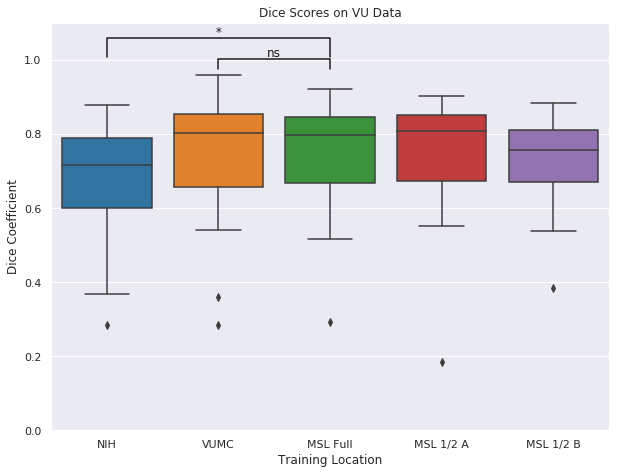

In [28]:
sns.set(rc={'figure.figsize':(10,7.5)})

ax = sns.boxplot(x="Training Location", y="Dice Coefficient", data=merged, palette="tab10", saturation=0.75
                #).set_title("Dice Scores on NIH Data"
                ).set_title("Dice Scores on VU Data"
                )
fig = ax.get_figure()
plt.ylim(0, 1.10)


x1, x2 = 0, 2   # columns 'nih' and 'multi' (first column: 0, see plt.xticks())
y, h, col = merged['Dice Coefficient'].max() + 0.05, 0.05, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)

x1, x2 = 1, 2   # columns 'nih' and 'multi' (first column: 0, see plt.xticks())
y, h, col = merged['Dice Coefficient'].max() + 0.0175, 0.025, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

fig.savefig("vu_data_boxplot.png")
#fig.savefig("nih_data_boxplot.png")

In [21]:
print("Wilcoxon between NIH weights, Multi weights")
print(wilcoxon(nih_df['dice'], msl_full_df['dice']))
print("Wilcoxon between NIH weights, MSL 1/2 A weights")
print(wilcoxon(nih_df['dice'], msl_half_df['dice']))
print("Wilcoxon between NIH weights, MSL 1/2 B weights")
print(wilcoxon(nih_df['dice'], msl_other_half_df['dice']))

Wilcoxon between NIH weights, Multi weights
WilcoxonResult(statistic=45.0, pvalue=0.0001914780974922042)
Wilcoxon between NIH weights, MSL 1/2 A weights
WilcoxonResult(statistic=61.0, pvalue=0.000714299422212305)
Wilcoxon between NIH weights, MSL 1/2 B weights
WilcoxonResult(statistic=148.0, pvalue=0.13288740647153138)


In [22]:
print("Wilcoxon between VU weights, Multi weights")
print(wilcoxon(vu_df['dice'], msl_full_df['dice']))
print("Wilcoxon between VU weights, MSL 1/2 A weights")
print(wilcoxon(vu_df['dice'], msl_half_df['dice']))
print("Wilcoxon between VU weights, MSL 1/2 B weights")
print(wilcoxon(vu_df['dice'], msl_other_half_df['dice']))

Wilcoxon between VU weights, Multi weights
WilcoxonResult(statistic=207.0, pvalue=0.820389829874258)
Wilcoxon between VU weights, MSL 1/2 A weights
WilcoxonResult(statistic=193.0, pvalue=0.5962724972882395)
Wilcoxon between VU weights, MSL 1/2 B weights
WilcoxonResult(statistic=135.0, pvalue=0.07443762498218096)
